## Garbage Collection

In [1]:
import ctypes
import gc

We use the same function that we used in the lesson on reference counting to calculate the number of references to a specified object (using its memory address to avoid creating an extra reference)

In [2]:
def ref_count(address):
    return ctypes.c_long.from_address(address).value

We create a function that will search the objects in the GC for a specified id and tell us if the object was found or not:

In [3]:
def object_by_id(object_id):
    for obj in gc.get_objects():
        if id(obj) == object_id:
            return "Object exists"
    return "Not found"

Next we define two classes that we will use to create a circular reference

Class A's constructor will create an instance of class B and pass itself to class B's constructor that will then store that reference in some instance variable.

In [4]:
class A:
    def __init__(self):
        self.b = B(self)
        print('A: self: {0}, b:{1}'.format(hex(id(self)), hex(id(self.b))))

In [5]:
class B:
    def __init__(self, a):
        self.a = a
        print('B: self: {0}, a: {1}'.format(hex(id(self)), hex(id(self.a))))

We turn off the GC so we can see how reference counts are affected when the GC does not run and when it does (by running it manually).

In [6]:
gc.disable()

Now we create an instance of A, which will, in turn, create an instance of B which will store a reference to the calling A instance.

In [7]:
my_var = A()

B: self: 0x1fc1eae44e0, a: 0x1fc1eae4908
A: self: 0x1fc1eae4908, b:0x1fc1eae44e0


As we can see A and B's constructors ran, and we also see from the memory addresses that we have a circular reference.

In fact `my_var` is also a reference to the same A instance:

In [8]:
print(hex(id(my_var)))

0x1fc1eae4908


Another way to see this:

In [9]:
print('a: \t{0}'.format(hex(id(my_var))))
print('a.b: \t{0}'.format(hex(id(my_var.b))))
print('b.a: \t{0}'.format(hex(id(my_var.b.a))))

a: 	0x1fc1eae4908
a.b: 	0x1fc1eae44e0
b.a: 	0x1fc1eae4908


In [10]:
a_id = id(my_var)
b_id = id(my_var.b)

We can see how many references we have for `a` and `b`:

In [11]:
print('refcount(a) = {0}'.format(ref_count(a_id)))
print('refcount(b) = {0}'.format(ref_count(b_id)))
print('a: {0}'.format(object_by_id(a_id)))
print('b: {0}'.format(object_by_id(b_id)))

refcount(a) = 2
refcount(b) = 1
a: Object exists
b: Object exists


As we can see the A instance has two references (one from `my_var`, the other from the instance variable `b` in the B instance)

The B instance has one reference (from the A instance variable `a`)

Now, let's remove the reference to the A instance that is being held by `my_var`:

In [12]:
my_var= None

In [13]:
print('refcount(a) = {0}'.format(ref_count(a_id)))
print('refcount(b) = {0}'.format(ref_count(b_id)))
print('a: {0}'.format(object_by_id(a_id)))
print('b: {0}'.format(object_by_id(b_id)))

refcount(a) = 1
refcount(b) = 1
a: Object exists
b: Object exists


As we can see, the reference counts are now both equal to 1 (a pure circular reference), and reference counting alone did not destroy the A and B instances - they're still around. If no garbage collection is performed this would result in a memory leak.

Let's run the GC manually and re-check whether the objects still exist:

In [14]:
gc.collect()
print('refcount(a) = {0}'.format(ref_count(a_id)))
print('refcount(b) = {0}'.format(ref_count(b_id)))
print('a: {0}'.format(object_by_id(a_id)))
print('b: {0}'.format(object_by_id(b_id)))

refcount(a) = 0
refcount(b) = 0
a: Not found
b: Not found


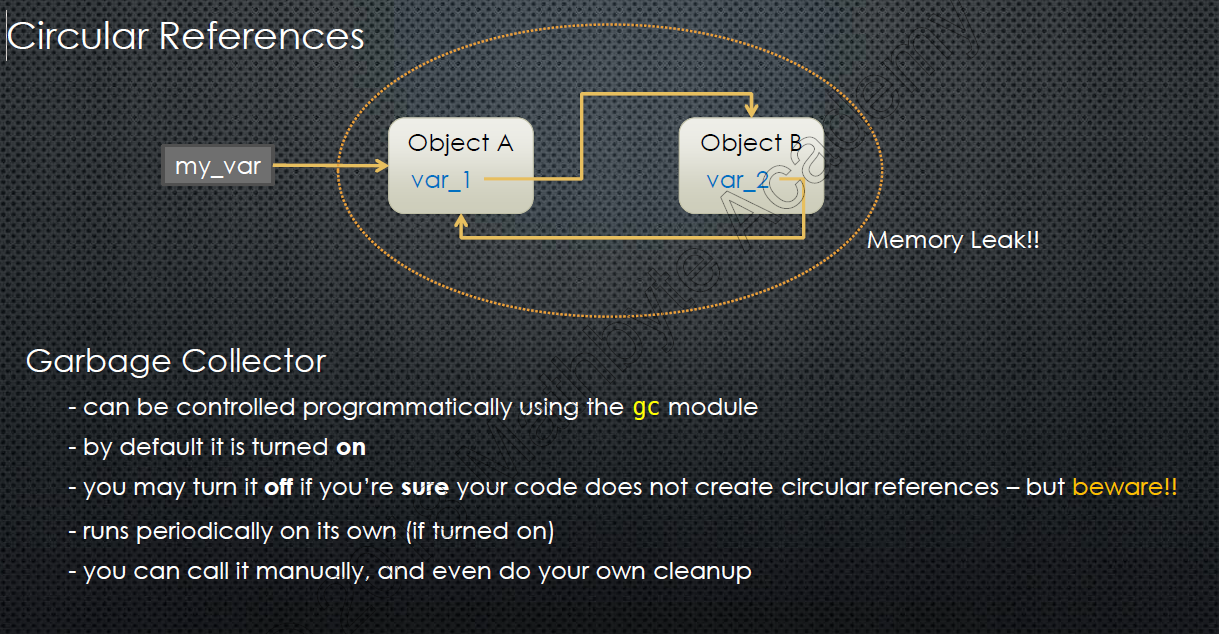

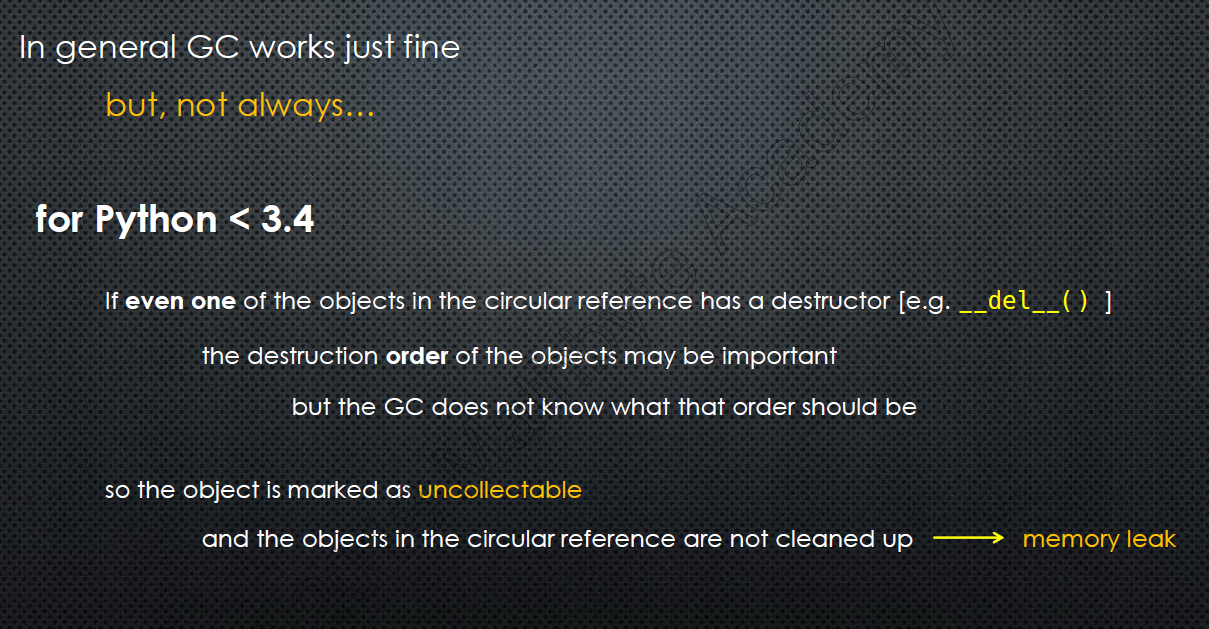